mask.npyを読み込んでセグメンテーションの評価を行う

In [15]:
#関数定義
import os, sys
import numpy as np

def obj_detection(mask, class_id:int):
    """
    Input:
        mask : [width, height](ndarray), image data
        class_id : int , class id(ex : 1day -> 1)
    Return:
        mask : [object num(int), width(int), height(int)]
        cls_idxs : [nobject num(int)]
    """
    data = mask
    labels = []
    for label in np.unique(data):
        #: ラベルID==0は背景
        if label == 0:
            continue
        else:
            labels.append(label)

    if len(labels) == 0:
        #: 対象オブジェクトがない場合はNone
        return None, None
    else:
        mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)
        for n, label in enumerate(labels):
            mask[:, :, n] = np.uint8(data == label)
        cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32) * class_id

        return mask.transpose(2, 0 ,1), cls_idxs

(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(19, 256, 256)


(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(256, 256)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(34, 256, 256)
(32, 256, 256)


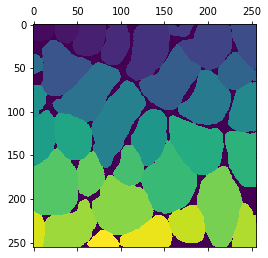

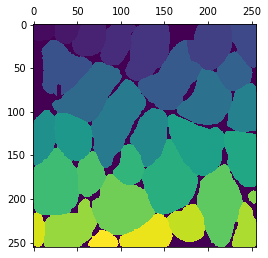

In [22]:
INF_PATH = "./Inference.npy"
TRUE_PATH = "./GroundTrue.npy"

inf_mask = np.load(INF_PATH)
print(inf_mask.shape)
print(np.unique(inf_mask))

true_mask = np.load(TRUE_PATH)
print(true_mask.shape)
print(np.unique(true_mask))

import matplotlib.pyplot as plt
plt.matshow(inf_mask)
plt.matshow(true_mask)

inf_masks, _ = obj_detection(inf_mask, 1)
true_masks, _ = obj_detection(true_mask, 1)
print(inf_masks.shape)
print(true_masks.shape)



In [26]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU) between two masks.

    Parameters:
    - mask1, mask2: Binary masks to calculate IoU.

    Returns:
    - IoU value.
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_f1_score(inf_masks, true_masks, iou_threshold=0.5):
    """
    Calculate F1 score based on IoU matching between inference masks and true masks.

    Parameters:
    - inf_masks: Inference masks.
    - true_masks: True masks.
    - iou_threshold: IoU threshold for considering a match.

    Returns:
    - Average F1 score.
    """
    def find_best_iou_match(inf_mask, true_masks, iou_threshold):
        """
        Find the best IoU match for a given inference mask among true masks.

        Parameters:
        - inf_mask: Inference mask.
        - true_masks: List of true masks.
        - iou_threshold: IoU threshold for considering a match.

        Returns:
        - True if a match is found, False otherwise.
        """
        best_iou = 0
        for true_mask in true_masks:
            iou = calculate_iou(inf_mask, true_mask)
            best_iou = max(best_iou, iou)
        return best_iou >= iou_threshold

    f1_scores = []

    for inf_mask in inf_masks:
        matching_indices = [find_best_iou_match(inf_mask, true_masks, iou_threshold)]
        precision, recall, f1, _ = precision_recall_fscore_support(np.array([True]), np.array(matching_indices), average='binary')
        f1_scores.append(f1)

    average_f1 = np.mean(f1_scores)

    return average_f1

# Example: Calculate F1 score with IOU threshold 0.5
f1_score = calculate_f1_score(inf_masks, true_masks, iou_threshold=0.5)
print("F1 Score:", f1_score)


/a/yu-yamaoka/anaconda3/envs/cell/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/a/yu-yamaoka/anaconda3/envs/cell/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/a/yu-yamaoka/anaconda3/envs/cell/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.9117647058823529
